In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import tarfile
from glob import glob
import csv
import gc
import time
import random
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import timm
import itertools 
import json
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, UnidentifiedImageError
import cv2
from collections import Counter, defaultdict, namedtuple

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torchinfo import summary as Summary

import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.transforms import ToPILImage
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from torchvision.transforms.functional import to_pil_image
import torchvision.utils as vutils
from torchvision.utils import make_grid, save_image, draw_bounding_boxes, draw_segmentation_masks
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print('All modules imported succesfully !')


torch.cuda.empty_cache()

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print(f"Device : { 'cuda' if torch.cuda.is_available() else 'cpu'}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

All modules imported succesfully !
CUDA Available: True
CUDA Device Count: 1
Device : cuda


In [3]:
class FaceMaskRemovalDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=None):
        self.masked_dir = os.path.join(root_dir, 'masked_images')
        self.original_dir = os.path.join(root_dir, 'original_images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.transform = transform
        self.paired_images = self._get_paired_images(num_samples)

    def _get_paired_images(self, num_samples=None):
        masked_images = glob(os.path.join(self.masked_dir, "*.jpg"))
        pairs = []
        if num_samples is not None:
            masked_images = masked_images[:min(len(masked_images), num_samples)]
        for masked_path in tqdm(masked_images):
            filename = os.path.basename(masked_path).split("_")[0] + ".jpg"
            original_path = os.path.join(self.original_dir, filename)
            mask_path = os.path.join(self.mask_dir, os.path.basename(masked_path).replace(".jpg", "_binary.jpg"))
            if os.path.exists(original_path) and os.path.exists(mask_path):
                pairs.append((masked_path, original_path, mask_path))
        return pairs

    def __len__(self):
        return len(self.paired_images)

    def __getitem__(self, idx):
        masked_path, original_path, mask_path = self.paired_images[idx]
    
        masked_img = Image.open(masked_path).convert("RGB")
        original_img = Image.open(original_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")
    
        masked_img = np.array(masked_img)
        original_img = np.array(original_img)
        mask_img = np.array(mask_img)
    
        if self.transform:
            augmented = self.transform(image=masked_img, image0=original_img, mask=mask_img)
            masked_img = augmented["image"]
            original_img = augmented["image0"]
            mask_img = augmented["mask"]
    
        mask_img = mask_img.unsqueeze(0).float()  # (1, H, W)
        masked_input = torch.cat([masked_img, mask_img], dim=0)  # (4, H, W)
    
        return {
            'image': original_img,  # (3, H, W)
            'masked_input': masked_input,  # (4, H, W)
            'mask': mask_img,  # (1, H, W)
            'masked_image': masked_img  # (3, H, W)
        }


# Parameters
image_size = 64

transform = A.Compose(
    [
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image", "mask": "mask"},
)

dataset = FaceMaskRemovalDataset(
    root_dir='/kaggle/input/gan-dataset-with-masks/image_align_celeba_with_masks',
    transform=transform,
    num_samples=50000,
)

100%|██████████| 50000/50000 [03:59<00:00, 208.52it/s]


In [4]:
batch_size = 128 
transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={"image0": "image", "mask": "mask"}) 


# Split into train and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, base_channels=64):
        super().__init__()
        
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=1)
        self.enc2 = nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.enc3 = nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1)
        
        # Middle
        self.mid = nn.Conv2d(base_channels*4, base_channels*4, kernel_size=3, padding=1)
        
        # Decoder
        self.dec3 = nn.ConvTranspose2d(base_channels*8, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(base_channels*4, base_channels, kernel_size=4, stride=2, padding=1)
        self.dec1 = nn.ConvTranspose2d(base_channels*2, out_channels, kernel_size=4, stride=2, padding=1)
        
        # Normalization layers
        self.norm1 = nn.InstanceNorm2d(base_channels)
        self.norm2 = nn.InstanceNorm2d(base_channels*2)
        self.norm4 = nn.InstanceNorm2d(base_channels*4)

    def forward(self, x):
        # Encoder
        e1 = F.leaky_relu(self.norm1(self.enc1(x)), 0.2)
        e2 = F.leaky_relu(self.norm2(self.enc2(e1)), 0.2)
        e3 = F.leaky_relu(self.norm4(self.enc3(e2)), 0.2)

        # Middle
        mid = F.leaky_relu(self.norm4(self.mid(e3)), 0.2)

        # Decoder with skip connections
        d3 = F.leaky_relu(self.norm2(self.dec3(torch.cat([mid, e3], 1))), 0.2)
        d2 = F.leaky_relu(self.norm1(self.dec2(torch.cat([d3, e2], 1))), 0.2)
        d1 = torch.tanh(self.dec1(torch.cat([d2, e1], 1)))

        return d1


In [24]:
model = UNet()

Summary(model)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─Conv2d: 1-1                            4,160
├─Conv2d: 1-2                            131,200
├─Conv2d: 1-3                            524,544
├─Conv2d: 1-4                            590,080
├─ConvTranspose2d: 1-5                   1,048,704
├─ConvTranspose2d: 1-6                   262,208
├─ConvTranspose2d: 1-7                   6,147
├─InstanceNorm2d: 1-8                    --
├─InstanceNorm2d: 1-9                    --
├─InstanceNorm2d: 1-10                   --
Total params: 2,567,043
Trainable params: 2,567,043
Non-trainable params: 0

In [25]:
class InpaintingTrainer:
    def __init__(self, unet, device, lambda_l1=1.0, lambda_bce=1.0):
        """
        Initialize the trainer for U-Net based segmentation (binary mask prediction).

        Args:
            unet: U-Net model for segmentation.
            device: 'cuda' or 'cpu'.
            lambda_l1: Weight for L1 loss.
            lambda_bce: Weight for Binary Cross-Entropy loss.
        """
        self.unet = unet.to(device)
        self.device = device
        self.l1_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Sigmoid activation is included
        self.lambda_l1 = lambda_l1
        self.lambda_bce = lambda_bce

    def iou_score(self, pred, target, threshold=0.5):
        """
        Compute Intersection over Union (IoU) for segmentation masks.

        Args:
            pred: Predicted mask logits (before sigmoid).
            target: Ground truth mask.
            threshold: Threshold to convert logits to binary predictions.

        Returns:
            IoU score.
        """
        pred = torch.sigmoid(pred) > threshold  # Convert logits to binary
        target = target > threshold

        intersection = (pred & target).float().sum(dim=(1, 2, 3))
        union = (pred | target).float().sum(dim=(1, 2, 3))

        iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
        return iou.mean().item()

    def train_step(self, batch, optimizer):
        """
        Perform a single training step.

        Args:
            batch: Batch from the dataloader.
            optimizer: Optimizer.

        Returns:
            Training metrics.
        """
        real_images = batch['image'].to(self.device)  # (B, 3, H, W)
        masks = batch['mask'].float().to(self.device) / 255.0  # Normalize to [0,1]

        self.unet.train()
        predicted_masks = self.unet(real_images)

        # Compute losses
        l1_loss = self.l1_loss(torch.sigmoid(predicted_masks), masks)
        bce_loss = self.bce_loss(predicted_masks, masks)

        # Total loss
        total_loss = self.lambda_l1 * l1_loss + self.lambda_bce * bce_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Compute IoU score
        batch_iou = self.iou_score(predicted_masks, masks)

        return {
            'total_loss': total_loss.item(),
            'l1_loss': l1_loss.item(),
            'bce_loss': bce_loss.item(),
            'iou': batch_iou
        }

    def train_epoch(self, dataloader, optimizer):
        """
        Train for one epoch.

        Args:
            dataloader: Training dataloader.
            optimizer: Optimizer.

        Returns:
            Averaged training metrics.
        """
        epoch_metrics = {'total_loss': 0, 'l1_loss': 0, 'bce_loss': 0, 'iou': 0}
        pbar = tqdm(dataloader, desc="Training")

        for batch in pbar:
            metrics = self.train_step(batch, optimizer)
            for key in epoch_metrics:
                epoch_metrics[key] += metrics[key]

            avg_metrics = {k: v / (pbar.n + 1) for k, v in epoch_metrics.items()}
            pbar.set_postfix({k: f"{v:.4f}" for k, v in avg_metrics.items()})

        return {k: v / len(dataloader) for k, v in epoch_metrics.items()}

    def validate_epoch(self, dataloader):
        """
        Validate the model for one epoch.

        Args:
            dataloader: Validation dataloader.

        Returns:
            Averaged validation metrics.
        """
        self.unet.eval()
        val_metrics = {'total_loss': 0, 'l1_loss': 0, 'bce_loss': 0, 'iou': 0}
        pbar = tqdm(dataloader, desc="Validating")

        with torch.no_grad():
            for batch in pbar:
                real_images = batch['image'].to(self.device)
                masks = batch['mask'].float().to(self.device) / 255.0

                predicted_masks = self.unet(real_images)

                l1_loss = self.l1_loss(torch.sigmoid(predicted_masks), masks)
                bce_loss = self.bce_loss(predicted_masks, masks)
                total_loss = self.lambda_l1 * l1_loss + self.lambda_bce * bce_loss

                batch_iou = self.iou_score(predicted_masks, masks)

                val_metrics['total_loss'] += total_loss.item()
                val_metrics['l1_loss'] += l1_loss.item()
                val_metrics['bce_loss'] += bce_loss.item()
                val_metrics['iou'] += batch_iou

                avg_metrics = {k: v / (pbar.n + 1) for k, v in val_metrics.items()}
                pbar.set_postfix({k: f"{v:.4f}" for k, v in avg_metrics.items()})

        return {k: v / len(dataloader) for k, v in val_metrics.items()}

    def visualize_batch(self, batch, save_path=None, num_images=8):
        """
        Visualize a batch of images:
        - Original Image
        - Ground Truth Mask
        - Model Prediction Mask
        """
        self.unet.eval()
        with torch.no_grad():
            real_images = batch['image'][:num_images].to(self.device)
            masks = batch['mask'][:num_images].float().to(self.device) / 255.0

            predicted_masks = torch.sigmoid(self.unet(real_images))  # Apply sigmoid

            # Denormalize images for visualization
            def denorm(x):
                return (x + 1) / 2  # Rescale to [0,1]

            real_images = denorm(real_images)
            masks = masks.repeat(1, 3, 1, 1)  # Convert to 3-channel for visualization
            predicted_masks = predicted_masks.repeat(1, 3, 1, 1)  # Convert to 3-channel

            # Create visualization grid (Original | Ground Truth | Prediction)
            vis_images = torch.cat([real_images, masks, predicted_masks], dim=0)
            grid = make_grid(vis_images, nrow=num_images, padding=2, normalize=False)

            # Convert to numpy for plotting
            grid_np = grid.cpu().numpy().transpose((1, 2, 0))

            # Plot
            plt.figure(figsize=(15, 7))
            plt.imshow(grid_np)
            plt.axis('off')
            plt.title("Original | Ground Truth Mask | Predicted Mask")

            if save_path:
                plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
                plt.show()
                plt.close()
            else:
                plt.show()

    def save_checkpoint(self, path, epoch, optimizer):
        """Save model checkpoint."""
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            'epoch': epoch,
            'unet_state_dict': self.unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, path)

    def load_checkpoint(self, path, optimizer=None):
        """Load model checkpoint."""
        checkpoint = torch.load(path)
        self.unet.load_state_dict(checkpoint['unet_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch']


In [26]:
def train_model(trainer, train_loader, val_loader, optimizer, 
                num_epochs, save_dir, save_freq=5, viz_freq=1, resume_path=None):
    """
    Training function for U-Net segmentation model with validation and visualization.

    Args:
        trainer: InpaintingTrainer instance
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: U-Net optimizer
        num_epochs: Number of epochs to train
        save_dir: Directory to save checkpoints and visualizations
        save_freq: Frequency of saving checkpoints
        viz_freq: Frequency of saving visualizations
        resume_path: Path to resume training from checkpoint
    """
    metrics_history = {'train_metrics': [], 'val_metrics': []}
    start_epoch = 0
    best_loss = float('inf')
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    vis_dir = os.path.join(save_dir, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)

    csv_path = os.path.join(save_dir, 'training_log.csv')

    # CSV header
    csv_header = [
        'epoch', 'train_total_loss', 'train_l1_loss', 'train_bce_loss', 'train_iou',
        'val_total_loss', 'val_l1_loss', 'val_bce_loss', 'val_iou'
    ]

    # Open CSV file for logging
    csv_file = open(csv_path, 'a', newline='')
    csv_writer = csv.writer(csv_file)

    # Write CSV header only if the file is empty
    if os.stat(csv_path).st_size == 0:
        csv_writer.writerow(csv_header)
    
    if resume_path and os.path.exists(resume_path):
        print(f"Resuming training from {resume_path}")
        start_epoch, metrics_history = trainer.load_checkpoint(resume_path, optimizer)
        print(f"Resumed from epoch {start_epoch}")
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"\nEpoch {epoch+1}/{start_epoch + num_epochs}")
        
        # Training
        train_metrics = trainer.train_epoch(train_loader, optimizer)
        metrics_history['train_metrics'].append(train_metrics)
        
        # Validation
        val_metrics = trainer.validate_epoch(val_loader)
        metrics_history['val_metrics'].append(val_metrics)
        
        # Print metrics at the end of training
        print("\nTraining metrics:")
        for k, v in train_metrics.items():
            print(f"{k}: {v:.4f}")
        print("\nValidation metrics:")
        for k, v in val_metrics.items():
            print(f"{k}: {v:.4f}")
        
        # Write metrics to CSV
        csv_writer.writerow([
            epoch + 1,
            train_metrics['total_loss'], train_metrics['l1_loss'], train_metrics['bce_loss'], train_metrics['iou'],
            val_metrics['total_loss'], val_metrics['l1_loss'], val_metrics['bce_loss'], val_metrics['iou']
        ])
        csv_file.flush()  # Ensure data is written to the file
        
        # Save best model
        if val_metrics['total_loss'] < best_loss:
            best_loss = val_metrics['total_loss']
            best_path = os.path.join(save_dir, "best_model.pth")
            trainer.save_checkpoint(best_path, epoch + 1, optimizer)
            print(f"Best model saved: {best_path}")
        
        # Regular checkpoint saving
        if (epoch + 1) % save_freq == 0:
            save_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
            trainer.save_checkpoint(save_path, epoch + 1, optimizer)
            print(f"Checkpoint saved: {save_path}")
        
        # Visualization
        if (epoch + 1) % viz_freq == 0:
            viz_path = os.path.join(vis_dir, f'epoch_{epoch+1:03d}.png')
            trainer.visualize_batch(next(iter(val_loader)), save_path=viz_path)
            print(f"Visualization saved: {viz_path}")
        
        # Memory cleanup
        gc.collect()
        if trainer.device == 'cuda':
            torch.cuda.empty_cache()

    # Close CSV file
    csv_file.close()

    # Save final model
    final_path = os.path.join(save_dir, "final_model.pth")
    trainer.save_checkpoint(final_path, epoch + 1, optimizer)
    print(f"Final model saved: {final_path}")

    print(f"Training log saved to {csv_path}")


Epoch 1/10


Validating: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s, total_loss=0.6594, l1_loss=0.2983, bce_loss=0.3611, iou=0.7920]



Training metrics:
total_loss: 0.7592
l1_loss: 0.3275
bce_loss: 0.4318
iou: 0.5444

Validation metrics:
total_loss: 0.6264
l1_loss: 0.2834
bce_loss: 0.3431
iou: 0.7524
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth

Epoch 2/10


Validating: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s, total_loss=0.6529, l1_loss=0.2958, bce_loss=0.3571, iou=0.8139]



Training metrics:
total_loss: 0.6228
l1_loss: 0.2820
bce_loss: 0.3408
iou: 0.7654

Validation metrics:
total_loss: 0.6203
l1_loss: 0.2811
bce_loss: 0.3392
iou: 0.7732
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth
Checkpoint saved: /kaggle/working/checkpoints_segmentation/checkpoint_epoch_2.pth


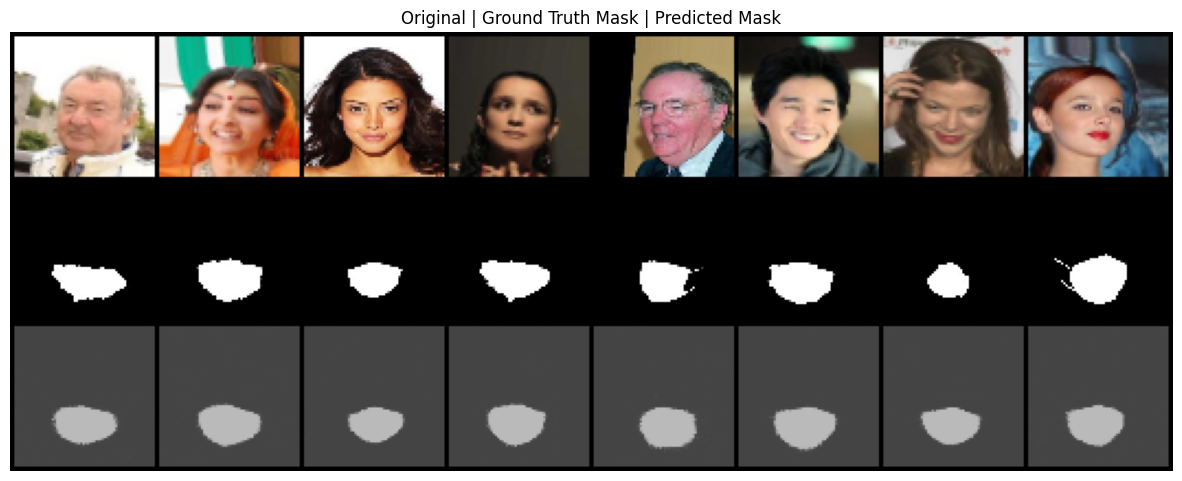

Visualization saved: /kaggle/working/checkpoints_segmentation/visualizations/epoch_002.png

Epoch 3/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s, total_loss=0.6514, l1_loss=0.2953, bce_loss=0.3561, iou=0.8177]



Training metrics:
total_loss: 0.6195
l1_loss: 0.2808
bce_loss: 0.3388
iou: 0.7767

Validation metrics:
total_loss: 0.6188
l1_loss: 0.2805
bce_loss: 0.3383
iou: 0.7768
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth

Epoch 4/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.17it/s, total_loss=0.6502, l1_loss=0.2948, bce_loss=0.3554, iou=0.8234]



Training metrics:
total_loss: 0.6183
l1_loss: 0.2803
bce_loss: 0.3380
iou: 0.7824

Validation metrics:
total_loss: 0.6177
l1_loss: 0.2801
bce_loss: 0.3376
iou: 0.7822
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth
Checkpoint saved: /kaggle/working/checkpoints_segmentation/checkpoint_epoch_4.pth


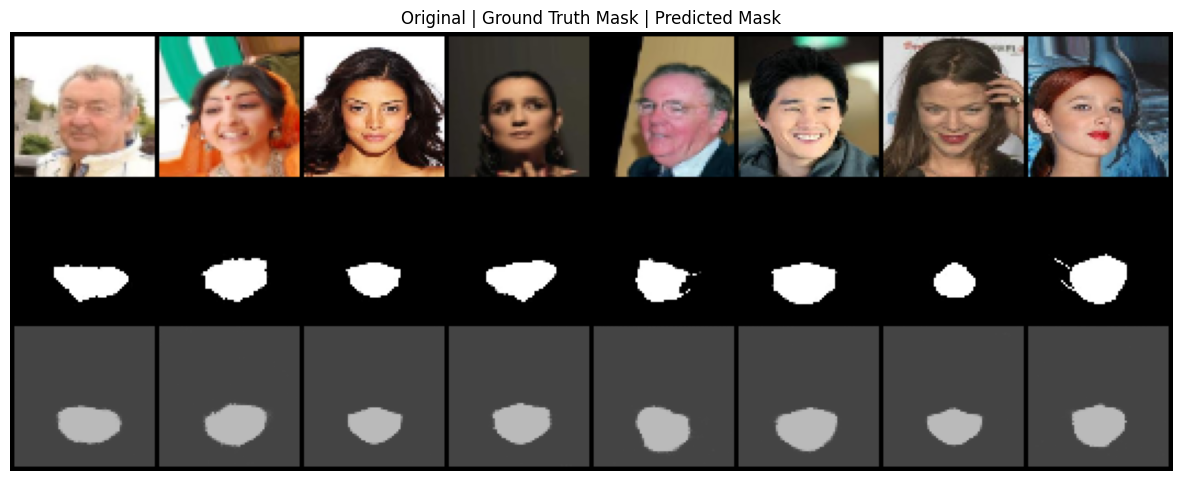

Visualization saved: /kaggle/working/checkpoints_segmentation/visualizations/epoch_004.png

Epoch 5/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s, total_loss=0.6494, l1_loss=0.2946, bce_loss=0.3548, iou=0.8306]



Training metrics:
total_loss: 0.6174
l1_loss: 0.2800
bce_loss: 0.3374
iou: 0.7866

Validation metrics:
total_loss: 0.6169
l1_loss: 0.2798
bce_loss: 0.3371
iou: 0.7890
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth

Epoch 6/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s, total_loss=0.6489, l1_loss=0.2944, bce_loss=0.3545, iou=0.8329]



Training metrics:
total_loss: 0.6169
l1_loss: 0.2798
bce_loss: 0.3371
iou: 0.7891

Validation metrics:
total_loss: 0.6164
l1_loss: 0.2797
bce_loss: 0.3368
iou: 0.7912
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth
Checkpoint saved: /kaggle/working/checkpoints_segmentation/checkpoint_epoch_6.pth


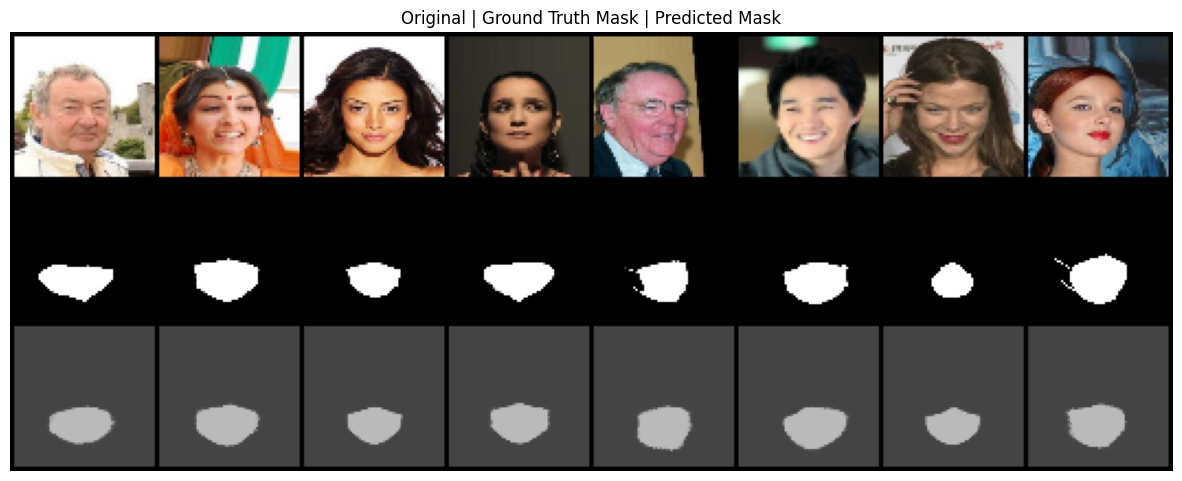

Visualization saved: /kaggle/working/checkpoints_segmentation/visualizations/epoch_006.png

Epoch 7/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s, total_loss=0.6485, l1_loss=0.2943, bce_loss=0.3543, iou=0.8337]



Training metrics:
total_loss: 0.6165
l1_loss: 0.2797
bce_loss: 0.3368
iou: 0.7915

Validation metrics:
total_loss: 0.6161
l1_loss: 0.2795
bce_loss: 0.3366
iou: 0.7920
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth

Epoch 8/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s, total_loss=0.6484, l1_loss=0.2942, bce_loss=0.3542, iou=0.8334]



Training metrics:
total_loss: 0.6162
l1_loss: 0.2796
bce_loss: 0.3366
iou: 0.7934

Validation metrics:
total_loss: 0.6160
l1_loss: 0.2795
bce_loss: 0.3365
iou: 0.7917
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth
Checkpoint saved: /kaggle/working/checkpoints_segmentation/checkpoint_epoch_8.pth


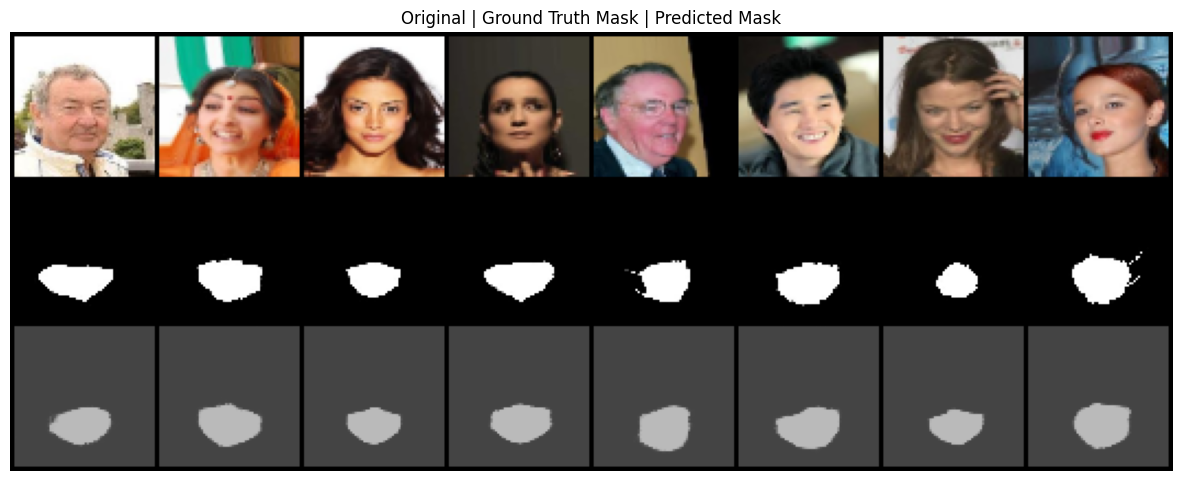

Visualization saved: /kaggle/working/checkpoints_segmentation/visualizations/epoch_008.png

Epoch 9/10


Validating: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s, total_loss=0.6314, l1_loss=0.2865, bce_loss=0.3449, iou=0.8158]



Training metrics:
total_loss: 0.6159
l1_loss: 0.2795
bce_loss: 0.3364
iou: 0.7952

Validation metrics:
total_loss: 0.6156
l1_loss: 0.2794
bce_loss: 0.3363
iou: 0.7954
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth

Epoch 10/10


Validating: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s, total_loss=0.6479, l1_loss=0.2940, bce_loss=0.3539, iou=0.8366]



Training metrics:
total_loss: 0.6156
l1_loss: 0.2794
bce_loss: 0.3363
iou: 0.7969

Validation metrics:
total_loss: 0.6155
l1_loss: 0.2793
bce_loss: 0.3362
iou: 0.7948
Best model saved: /kaggle/working/checkpoints_segmentation/best_model.pth
Checkpoint saved: /kaggle/working/checkpoints_segmentation/checkpoint_epoch_10.pth


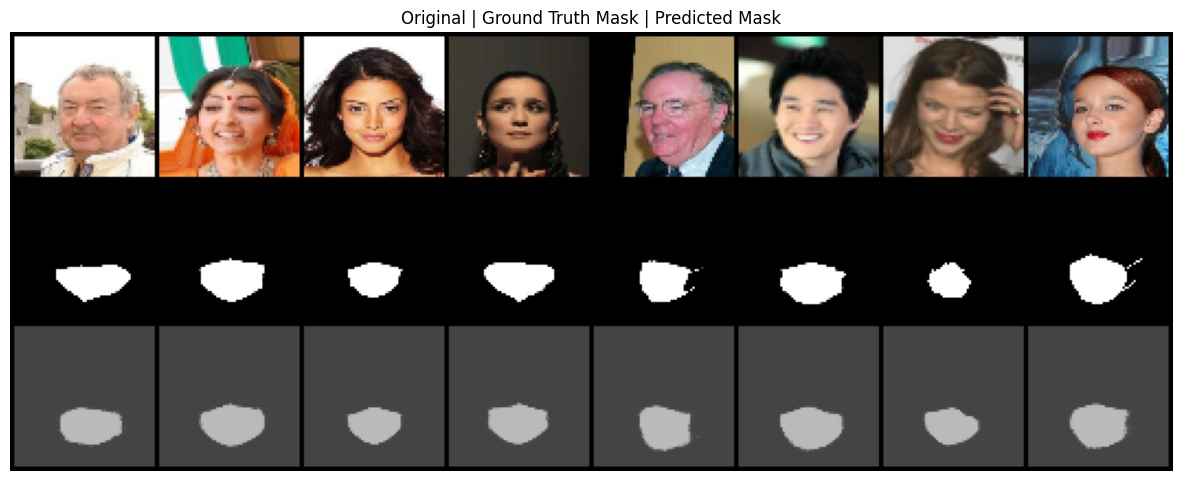

Visualization saved: /kaggle/working/checkpoints_segmentation/visualizations/epoch_010.png
Final model saved: /kaggle/working/checkpoints_segmentation/final_model.pth
Training log saved to /kaggle/working/checkpoints_segmentation/training_log.csv


In [27]:
# Initialize models
unet = UNet(in_channels=3, out_channels=1).to('cuda')  # Segmentation model with binary output

# Optimizers
optimizer = optim.Adam(unet.parameters(), lr=1e-4, betas=(0.9, 0.999))

# Initialize trainer
trainer = InpaintingTrainer(
    unet=unet,
    device='cuda',
    lambda_l1=1.0,  # Keep L1 loss for smoothness
    lambda_bce=1.0  # Use BCE loss for binary mask
)

# Train model
train_model(
    trainer=trainer,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='/kaggle/working/checkpoints_segmentation',  # Updated save directory
    save_freq=2,
    viz_freq=2,
    resume_path='/kaggle/working/checkpoints_segmentation/best_model.pth'  # Updated checkpoint path
)